In [1]:
import random
import networkx as nx
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path

def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']
title_ = Path(nbname).stem.replace('-', '_').title()
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)


In [2]:
def visme(G, m=None):
    def norm_size(sz):
        return int(sz*100)

    pos = nx.get_node_attributes(G, "pos")
    if not pos:
        pos = nx.shell_layout(G)
    cut_edges = None 
    v_colors = ['blue'] * len(G.nodes()) # цвета вершин
    if m:
        cut_edges = [e for e in m.E if pyo.value(m.y[e])>0]
        val_ = 0
        for v in G.nodes():
            if m.x[v].value is not None:
                val_ = m.x[v].value
            if val_ > 0:
                v_colors[v] = 'green'

    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        edge_color="green",
        node_color=v_colors,
        node_size=300,
        style=':',
        width=0.4,
        font_size=6
    )

    if cut_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=cut_edges,
            edge_color="blue",
            node_size=200,
            width=0.7,
        )


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


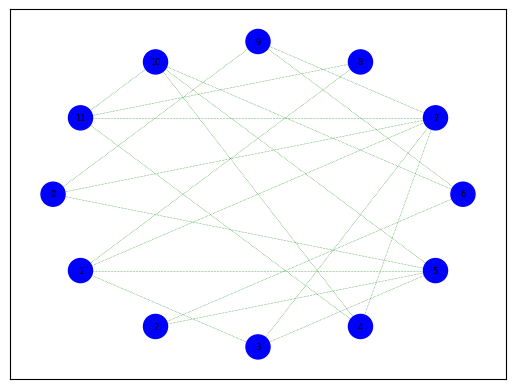

In [3]:
G = nx.fast_gnp_random_graph(12, 0.4)
print(G.nodes())

for (u, v) in G.edges():
    G.edges[u, v]['weight'] = 1 #np.random.rand()

visme(G)

# У нас в лекциях, кстати, не ЦЛП!

![image.png](./pics/max-cut-vp-is-not-ilp.png )



In [4]:
def get_model(G):
    m = pyo.ConcreteModel()
    m.E = list(G.edges())
    # m.E = list(G.edges(data=True))
    m.V = list(G.nodes())
    m.W = dict([(e[:2], e[2]['weight']) for e in G.edges(data=True)])
    m.m = len(m.E)
    m.n = len(m.V)

    # 0-1 — в левом или правом разбиении.
    m.x = pyo.Var(m.V, domain=pyo.Binary)

    # 0-1 — на разрезе или нет.
    m.y = pyo.Var(m.E, domain=pyo.Binary)

    m.cut_weight = pyo.Objective(expr = sum(m.W[e] * m.y[e] for e in m.E), sense=pyo.maximize)

    @m.Constraint(m.E)
    def ребро_на_разрезе_только_когда_вершины_в_разных_разбиениях_00(m, u, v):
        # u=0, v=0 → y=0
        return m.y[(u, v)] <= m.x[u] + m.x[v]

    @m.Constraint(m.E)
    def ребро_на_разрезе_только_когда_вершины_в_разных_разбиениях_11(m, u, v):
        # 1,1 → 0
        return m.y[(u, v)] <= 2 - m.x[u] - m.x[v]

    return m


m = get_model(G)
#m.E, m.V

In [9]:
solver = pyo.SolverFactory('cbc')
#solver = pyo.SolverFactory('scip')
solver.solve(m).write()
print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17.0
  Upper bound: 17.0
  Number of objectives: 1
  Number of constraints: 42
  Number of variables: 33
  Number of binary variables: 33
  Number of integer variables: 33
  Number of nonzeros: 21
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.06
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

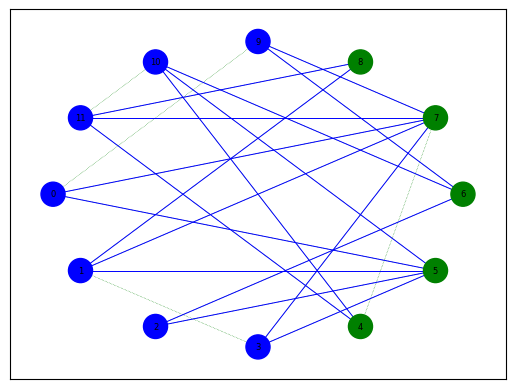

In [6]:
visme(G, m)


Пометим 

